<a href="https://colab.research.google.com/github/himanshu63867/Machine-Learning-Projects/blob/main/Predictive_Analytics_for_Identifying_Sales_%26_Supply_Chain_Problems_in_FMCG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business problems discovered**

# Low sales (most frequent)
 — Many SKUs show units sold below half of their historical median on specific days. This suggests either low demand windows, incorrect stocking/pricing, or missing promotions. Action: identify SKUs and periods to run targeted marketing or adjust inventory.

# High price relative to SKU average
— Many rows appear as “high price” (z > 1.5). High relative price correlates with lower sales for a number of SKUs. Action: price optimization and competitor benchmarking.

# Ineffective promotions
— Some promoted rows sold less (or not more) than the non-promo median for the same SKU. Action: re-evaluate promotion targeting, channel mix, timing, and product eligibilities.

# Stockout events (rare in the data)
— Very few rows matched stock_available <= 0 & delivered_qty <= 0. If true, these are critical: supply failure / missed restocking — prioritize these SKUs/regions.

# Delivery delays
— Based on the 90th percentile per region none (or very few) were flagged in this dataset run. That means delivery_days appear mostly within expected limits; if you have external SLA targets, consider using absolute thresholds.

# **Columns in Dataset**

date → Transaction date (2022–2024 range).

sku, brand, segment, category → Product details.

channel → Retail, Discount, etc.

region → PL-Central, PL-North, PL-South …

pack_type → Single / Multipack / Carton etc.

price_unit → Unit price of product.

promotion_flag → 1 = promotion, 0 = no promotion.

delivery_days → Time taken to deliver order.

stock_available → Inventory available at the time.

delivered_qty → Quantity delivered.

units_sold → Final units sold to customers.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib


In [3]:
# If file is in Colab working directory
df = pd.read_csv("/content/FMCG_2022_2024.csv")

print("Initial shape:", df.shape)
print("Columns:", df.columns)
print(df.head())

Initial shape: (190757, 14)
Columns: Index(['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region',
       'pack_type', 'price_unit', 'promotion_flag', 'delivery_days',
       'stock_available', 'delivered_qty', 'units_sold'],
      dtype='object')
         date     sku     brand    segment category   channel      region  \
0  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk    Retail  PL-Central   
1  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk    Retail    PL-North   
2  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk    Retail    PL-South   
3  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk  Discount  PL-Central   
4  2022-01-21  MI-006  MiBrand1  Milk-Seg3     Milk  Discount    PL-North   

   pack_type  price_unit  promotion_flag  delivery_days  stock_available  \
0  Multipack        2.38               0              1              141   
1     Single        1.55               1              3                0   
2     Carton        4.00               0        

In [4]:
#  Basic Cleaning

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Numeric conversions
num_cols = ['price_unit', 'delivery_days', 'stock_available', 'delivered_qty', 'units_sold']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nMissing values:")
print(df.isnull().sum())


Missing values:
date               0
sku                0
brand              0
segment            0
category           0
channel            0
region             0
pack_type          0
price_unit         0
promotion_flag     0
delivery_days      0
stock_available    0
delivered_qty      0
units_sold         0
dtype: int64


In [5]:
#Feature Engineering
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

# Median units_sold per SKU
sku_medians = df.groupby('sku')['units_sold'].median()

# Price z-score per SKU
df['price_zscore'] = df.groupby('sku')['price_unit'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-9)
)

In [6]:
# Business Problem Flags


# 1) Low sales
df['low_sales_flag'] = df.apply(
    lambda r: 1 if r['units_sold'] < 0.5*sku_medians.get(r['sku'], 0) else 0,
    axis=1
)

# 2) Stockout
df['stockout_flag'] = ((df['stock_available'] <= 0) & (df['delivered_qty'] <= 0)).astype(int)

# 3) Delivery delay (90th percentile by region)
delay_threshold = df.groupby('region')['delivery_days'].transform(
    lambda x: x.quantile(0.9)
)
df['delivery_delay_flag'] = (df['delivery_days'] > delay_threshold).astype(int)

In [7]:
# 4) Promotion ineffective
sku_nonpromo = df[df['promotion_flag'] == 0].groupby('sku')['units_sold'].median()
df['promotion_ineffective_flag'] = df.apply(
    lambda r: 1 if (r['promotion_flag']==1 and r['units_sold'] <= sku_nonpromo.get(r['sku'],0)) else 0,
    axis=1
)

# 5) High price
df['high_price_flag'] = (df['price_zscore'] > 1.5).astype(int)

# Combine to single target
df['has_problem'] = df[['low_sales_flag','stockout_flag','delivery_delay_flag',
                        'promotion_ineffective_flag','high_price_flag']].max(axis=1)

print("\nProblem counts:")
print(df[['low_sales_flag','stockout_flag','delivery_delay_flag',
          'promotion_ineffective_flag','high_price_flag','has_problem']].sum())

print("\nProblem percentage:", round(100*df['has_problem'].mean(),2), "%")


Problem counts:
low_sales_flag                17369
stockout_flag                     3
delivery_delay_flag               0
promotion_ineffective_flag     3150
high_price_flag               12711
has_problem                   31144
dtype: int64

Problem percentage: 16.33 %


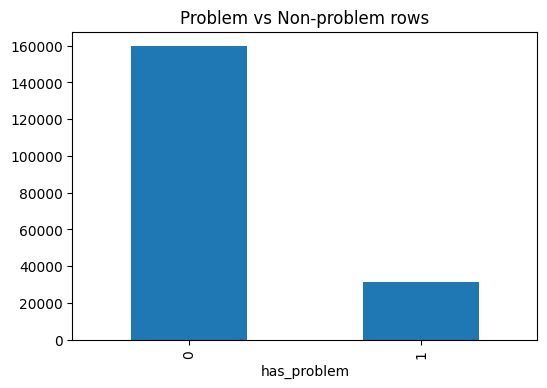

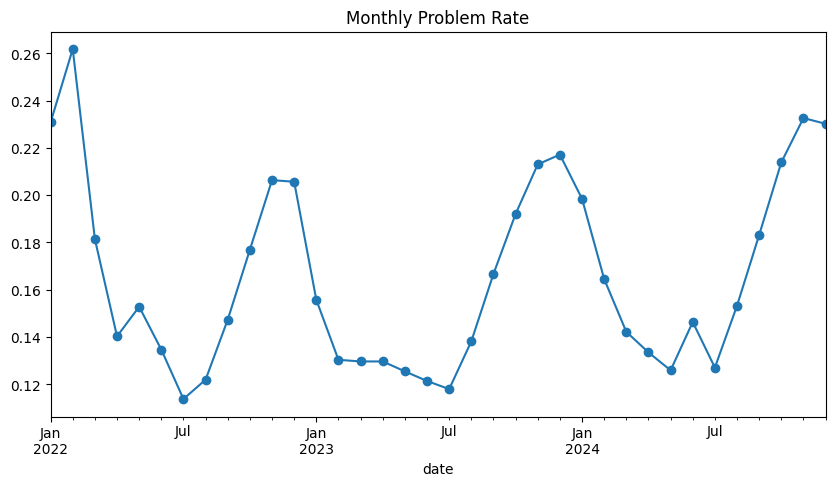

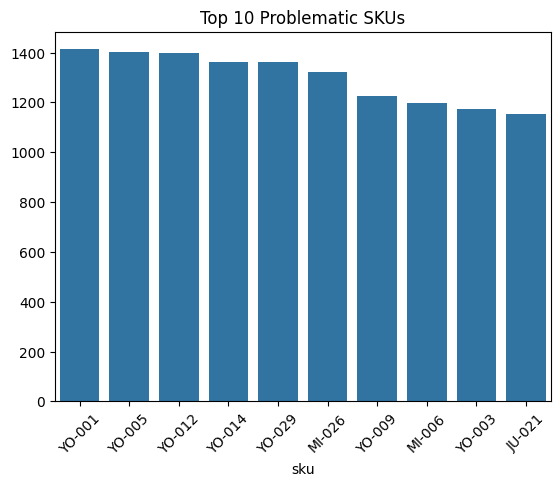

In [8]:

# : EDA Plots

plt.figure(figsize=(6,4))
df['has_problem'].value_counts().plot(kind='bar')
plt.title("Problem vs Non-problem rows")
plt.show()

monthly = df.groupby(df['date'].dt.to_period('M'))['has_problem'].mean()
monthly.plot(figsize=(10,5), marker='o')
plt.title("Monthly Problem Rate")
plt.show()

# Top SKUs with problems
top_skus = df[df['has_problem']==1]['sku'].value_counts().head(10)
sns.barplot(x=top_skus.index, y=top_skus.values)
plt.xticks(rotation=45)
plt.title("Top 10 Problematic SKUs")
plt.show()

In [9]:

#  Predictive Modeling
# Encode categoricals
cat_cols = ['sku','brand','segment','category','channel','region','pack_type']
df_model = df.copy()
for c in cat_cols:
    df_model[c] = LabelEncoder().fit_transform(df_model[c].astype(str))

features = cat_cols + ['price_unit','promotion_flag','delivery_days',
                       'stock_available','delivered_qty','units_sold',
                       'year','month','dayofweek','price_zscore']
X = df_model[features]
y = df_model['has_problem']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))



Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31923
           1       1.00      1.00      1.00      6229

    accuracy                           1.00     38152
   macro avg       1.00      1.00      1.00     38152
weighted avg       1.00      1.00      1.00     38152

ROC AUC: 0.9999917173068864


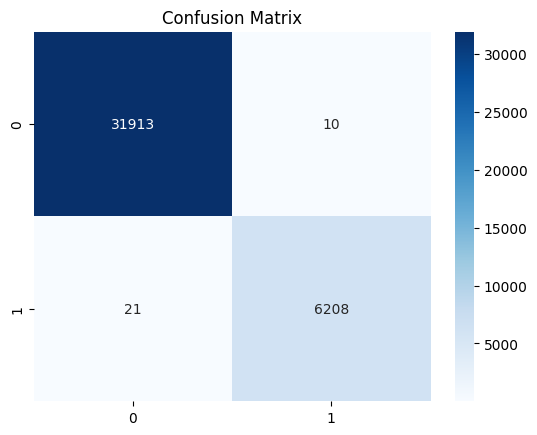

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

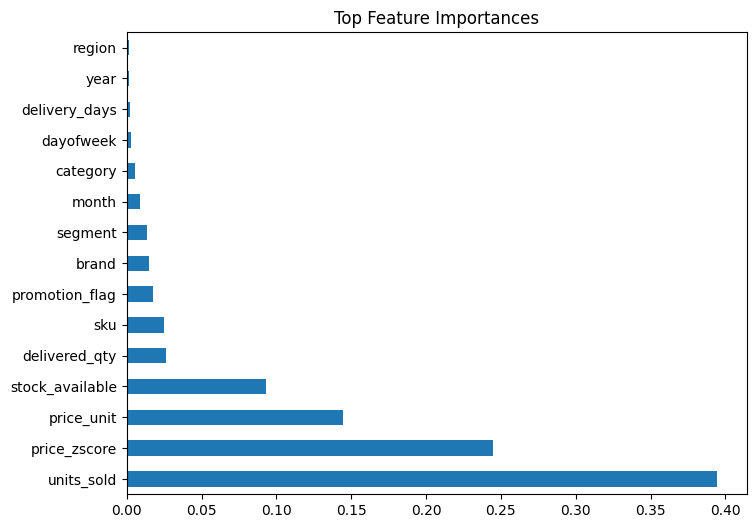

In [12]:
# Feature importance
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False).head(15)
importances.plot(kind='barh', figsize=(8,6))
plt.title("Top Feature Importances")
plt.show()

In [13]:
# Save model
joblib.dump(clf, "fmcg_problem_rf_model.joblib")
print("Model saved as fmcg_problem_rf_model.joblib")


Model saved as fmcg_problem_rf_model.joblib
